Just as naive Bayes is a good starting point for classification tasks, linear regression models are a good starting point for regression tasks. Such models are popular because they can be fit very quickly, and are very interpretable.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')

We will start with the most familiar linear regression, a straight-line fit to data. A straight-line fit is a model of the form $$y = ax + b$$ where a is commonly known as the slope, and b is commonly known as the intercept.

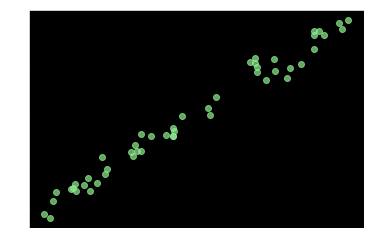

In [2]:
# создадим данные разбросанные примерно по одной линии
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y, color='lightgreen', alpha=0.7);

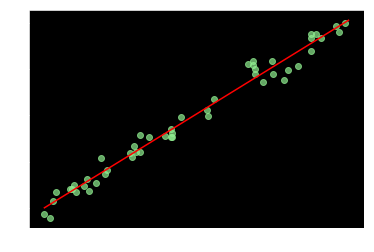

In [3]:
# построим лин.регр. модель по этим данным
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)
model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 100)
yfit = model.predict(xfit.reshape(-1,1))

plt.scatter(x, y, color='lightgreen', alpha=0.7)
plt.plot(xfit, yfit, color='red');

In [4]:
# slop & intercept of the are contained in the model fit
# parameters. We can look at them like this:
print(model.coef_)
print(model.intercept_)

# видно, что эти значения близки к исходным данным данных

[2.02720881]
-4.9985770855532055




The LinearRegression estimator is much more capable than this, however—in addition to simple straight-line fits, it can also handle multidimensional linear models of the form $$ y = a_0 + a_1 x_1 + a_2 x_2 + \cdots $$ where there are multiple $x$ values. Geometrically, this is akin to fitting a plane to points in three dimensions, or fitting a hyper-plane to points in higher dimensions.

The multidimensional nature of such regressions makes them more difficult to visualize, but we can see one of these fits in action by building some example data, using NumPy's matrix multiplication operator:


In [5]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])

model.fit(X, y)
print(model.intercept_)
print(model.coef_)

0.5000000000000038
[ 1.5 -2.   1. ]


Here the $y$ data is constructed from three random $x$ values, and the linear regression recovers the coefficients used to construct the data.

In this way, we can use the single LinearRegression estimator to fit lines, planes, or hyperplanes to our data. It still appears that this approach would be limited to strictly linear relationships between variables, but it turns out we can relax this as well

# Basis Function Regression

One trick you can use to adapt linear regression to nonlinear relationships between variables is to transform the data according to basis functions. The idea is to take our multidimensional linear model: $$ y = a_0 + a_1 x_1 + a_2 x_2 + a_3 x_3 + \cdots $$ and build the $x_1, x_2, x_3,$ and so on, from our single-dimensional input $x$. That is, we let $x_n = f_n(x)$, where $f_n()$ is some function that transforms our data.


## Polynomial basis functions

This polynomial projection is useful enough that it is built into Scikit-Learn, using the PolynomialFeatures transformer

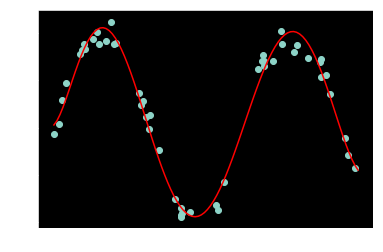

In [6]:
# создадим пайплайн применяющий PolynomialFeatures и затем лин.регр.
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

# создадим данные в виде синусоиды с шумом
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

# применим к ним модель использующую PolynomialFeatures через pipeline
poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit, color='red');

# в итоге наша ЛИНЕЙНАЯ модель построенная through the use of
# 7th-order polynomial basis functions отлично описывает эти нелинейные данные

## Gaussian basis functions

Можно юзать и други базисные функции. И если нам кажется что для нашего сета можно использовать другую функцию-генератор (приближенно описывающюю генерацию наших данных) то можно самим эту функцию задать.

В этом примере авторы сами gaussian-basis function, которых нет в sklearn.

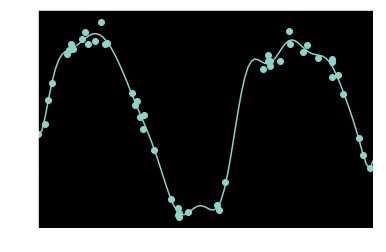

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)
    
gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10);

# Regularization

Используя basis functions можно очень легко получить оверфит. For example, if we choose too many Gaussian basis functions, we end up with results that don't look so good:

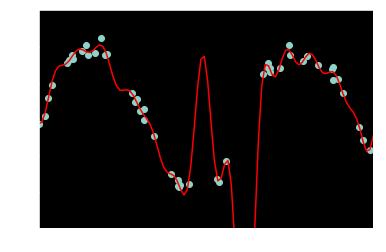

In [8]:
model = make_pipeline(GaussianFeatures(30),
                      LinearRegression())
model.fit(x[:, np.newaxis], y)

plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]), color='red')
plt.xlim(0, 10)
plt.ylim(-1.5, 1.5);

Поставилили 30-ти мерный базис и получили оверфит из-за слишком большой гибкости модели. Это произошло в силу того что коэф-ты гауссовского базиса начали принимать очень большие значения и ушли в "колебания с большой амплитудой".

Создадим функцию чтобы посмотреть на наш график и коэф-ты гауссовского базиса

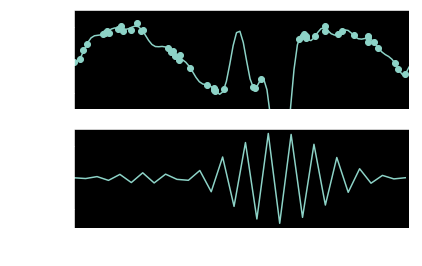

In [10]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)

    ax[1].plot(model.steps[0][1].centers_,
               model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
              ylabel='coefficient',
              xlim=(0, 10))
    
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

На нижнем графике показаны амплитуды базисной функции. Это типичный оверфит.

Чтоб с этим бороться нужно присекать подобные всплески. Для этого и нужна регуляция.

## Ridge regression ($L_2$ Regularization)

Perhaps the most common form of regularization is known as ridge regression or $L_2$ regularization, sometimes also called Tikhonov regularization. This proceeds by penalizing the sum of squares (2-norms) of the model coefficients; in this case, the penalty on the model fit would be $$ P = \alpha\sum_{n=1}^N \theta_n^2 $$ where $\alpha$ is a free parameter that controls the strength of the penalty. This type of penalized model is built into Scikit-Learn with the Ridge estimator

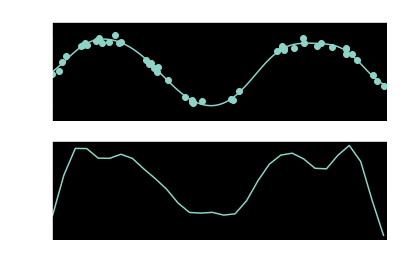

In [19]:
from sklearn.linear_model import Ridge

# поставили альфу = 0.1, а результат уже гораздо лучше
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regression')

The $\alpha$ parameter is essentially a knob controlling the complexity of the resulting model. In the limit $\alpha \to 0$, we recover the standard linear regression result; in the limit $\alpha \to \infty$, all model responses will be suppressed. One advantage of ridge regression in particular is that it can be computed very efficiently—at hardly more computational cost than the original linear regression mode.

## Lasso regression ($L_1$ regularization)

Another very common type of regularization is known as lasso, and involves penalizing the sum of absolute values (1-norms) of regression coefficients: $$ P = \alpha\sum_{n=1}^N |\theta_n| $$ Though this is conceptually very similar to ridge regression, the results can differ surprisingly: for example, due to geometric reasons lasso regression tends to favor sparse models where possible: that is, it preferentially sets model coefficients to exactly zero.

Let`s see how lasso regularization works:

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


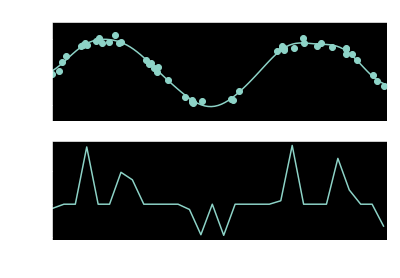

In [20]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001))
basis_plot(model, title='Lasso Regression')

With the lasso regression penalty, the majority of the coefficients are exactly zero, with the functional behavior being modeled by a small subset of the available basis functions. As with ridge regularization, the $\alpha$ parameter tunes the strength of the penalty, and should be determined via, for example, cross-validation.

# Example - predicting bicycle traffic

Let's take a look at whether we can predict the number of bicycle trips across Seattle's Fremont Bridge based on weather, season, and other factors. We will use 2 datasets: FremontBridge.csv & BicycleWeather.csv.

In particular, this is an example of how the tools of Scikit-Learn can be used in a statistical modeling framework, in which the parameters of the model are assumed to have interpretable meaning. As discussed previously, this is not a standard approach within machine learning, but such interpretation is possible for some models.

In [26]:
# скачать сет weather и закинуть его в нужную папку
import pandas as pd

counts = pd.read_csv('C:/Users/Администратор/Documents/Data_folder/FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('C:/Users/Администратор/Documents/Data_folder/Weather, USW00024233, 2009.01-2019.09.csv', index_col='DATE', parse_dates=True)

daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis='columns')
daily = daily[['Total']] # remove other columns